# 03. Training Single Models (Baseline)

## Muc tieu
- Train cac model don le de lam baseline
- Hyperparameter tuning voi Optuna
- Danh gia va so sanh cac model
- Uu tien metrics: Recall va F1-Score (bai toan y te)

**Cac model trong file nay:**
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Naive Bayes (GaussianNB)
- Decision Tree
- MLP Classifier (Multi-Layer Perceptron)
- SGDClassifier (Linear SVM)

In [1]:
# Import thu vien
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Sklearn models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Optuna cho hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Cau hinh
RANDOM_STATE = 42
N_FOLDS = 5  # 5-Fold Stratified CV
N_OPTUNA_TRIALS = 50  # So lan thu Optuna

plt.style.use('seaborn-v0_8-whitegrid')

/Users/kotori/miniconda/envs/py311_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load du lieu da xu ly

In [2]:
# Load du lieu
X_train = np.load('data/X_train.npy')
X_val = np.load('data/X_val.npy')
X_test = np.load('data/X_test.npy')
y_train = np.load('data/y_train.npy')
y_val = np.load('data/y_val.npy')
y_test = np.load('data/y_test.npy')
feature_names = np.load('data/feature_names.npy', allow_pickle=True)

print("Da load du lieu:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  Features: {list(feature_names)}")

Da load du lieu:
  X_train: (48046, 14)
  X_val: (10296, 14)
  X_test: (10296, 14)
  Features: [np.str_('age_years'), np.str_('gender'), np.str_('height'), np.str_('weight'), np.str_('ap_hi'), np.str_('ap_lo'), np.str_('cholesterol'), np.str_('gluc'), np.str_('smoke'), np.str_('alco'), np.str_('active'), np.str_('bmi'), np.str_('pulse_pressure'), np.str_('map')]


In [3]:
# Ket hop train va val de co bo train lon hon cho tuning
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

print(f"\nTrain + Val combined: {X_train_full.shape}")


Train + Val combined: (58342, 14)


## 2. Dinh nghia ham danh gia

In [4]:
def evaluate_model(model, X, y, model_name="Model"):
    """
    Danh gia model va tra ve dictionary cac metrics
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_proba) if y_proba is not None else None
    }
    
    return metrics, y_pred, y_proba


def print_metrics(metrics, model_name):
    """
    In ket qua metrics
    """
    print(f"\n{'='*50}")
    print(f"KET QUA: {model_name}")
    print(f"{'='*50}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}  <- Quan trong!")
    print(f"  F1-Score:  {metrics['f1']:.4f}  <- Quan trong!")
    if metrics['roc_auc']:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")


def plot_confusion_matrix(y_true, y_pred, model_name, ax=None):
    """
    Ve confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Khong benh', 'Co benh'],
                yticklabels=['Khong benh', 'Co benh'])
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Thuc te')
    ax.set_xlabel('Du doan')
    return cm

## 3. Define Optuna Objective Functions

In [5]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)


def objective_logistic(trial):
    """Optuna objective cho Logistic Regression"""
    params = {
        'C': trial.suggest_float('C', 0.01, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'saga',
        'max_iter': 1000,
        'random_state': RANDOM_STATE
    }
    
    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()


def objective_knn(trial):
    """Optuna objective cho KNN"""
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan']),
        'n_jobs': -1
    }
    
    model = KNeighborsClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()


def objective_decision_tree(trial):
    """Optuna objective cho Decision Tree"""
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': RANDOM_STATE
    }
    
    model = DecisionTreeClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()


def objective_mlp(trial):
    """Optuna objective cho MLP Classifier"""
    # Thu nhieu cau hinh hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 2)
    hidden_sizes = []
    for i in range(n_layers):
        hidden_sizes.append(trial.suggest_int(f'n_units_{i}', 32, 128))
    
    params = {
        'hidden_layer_sizes': tuple(hidden_sizes),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'max_iter': 500,
        'random_state': RANDOM_STATE
    }
    
    model = MLPClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()


def objective_sgd(trial):
    """Optuna objective cho SGDClassifier (Linear SVM)"""
    params = {
        'loss': 'hinge',  # Linear SVM
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'max_iter': 1000,
        'random_state': RANDOM_STATE
    }
    
    # elasticnet can l1_ratio
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.1, 0.9)
    
    model = SGDClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

## 4. Train va Tune cac Models

In [6]:
# Dictionary luu ket qua
results = {}
trained_models = {}
best_params = {}

### 4.1 Logistic Regression

In [7]:
print("\n" + "="*60)
print("TRAINING: Logistic Regression")
print("="*60)

# Optuna tuning
sampler = TPESampler(seed=RANDOM_STATE)
study_lr = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_lr.optimize(objective_logistic, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_lr.best_value:.4f}")
print(f"Best params: {study_lr.best_params}")

# Train voi best params
best_params['LogisticRegression'] = study_lr.best_params
model_lr = LogisticRegression(
    **study_lr.best_params,
    solver='saga',
    max_iter=1000,
    random_state=RANDOM_STATE
)

start_time = time.time()
model_lr.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

# Danh gia tren test set
metrics_lr, y_pred_lr, y_proba_lr = evaluate_model(model_lr, X_test, y_test)
metrics_lr['train_time'] = train_time
metrics_lr['tune_time'] = tune_time

results['LogisticRegression'] = metrics_lr
trained_models['LogisticRegression'] = model_lr

print_metrics(metrics_lr, 'Logistic Regression')


TRAINING: Logistic Regression


Best trial: 32. Best value: 0.706552: 100%|██████████| 50/50 [08:32<00:00, 10.26s/it]



Tuning time: 512.78s
Best F1 (CV): 0.7066
Best params: {'C': 0.15484779357506606, 'penalty': 'l1'}

KET QUA: Logistic Regression
  Accuracy:  0.7262
  Precision: 0.7543
  Recall:    0.6623  <- Quan trong!
  F1-Score:  0.7053  <- Quan trong!
  ROC-AUC:   0.7908


### 4.2 K-Nearest Neighbors (KNN)

In [8]:
print("\n" + "="*60)
print("TRAINING: K-Nearest Neighbors")
print("="*60)

# Optuna tuning
sampler = TPESampler(seed=RANDOM_STATE)
study_knn = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_knn.optimize(objective_knn, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_knn.best_value:.4f}")
print(f"Best params: {study_knn.best_params}")

# Train voi best params
best_params['KNN'] = study_knn.best_params
model_knn = KNeighborsClassifier(
    **study_knn.best_params,
    n_jobs=-1
)

start_time = time.time()
model_knn.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

# Danh gia
metrics_knn, y_pred_knn, y_proba_knn = evaluate_model(model_knn, X_test, y_test)
metrics_knn['train_time'] = train_time
metrics_knn['tune_time'] = tune_time

results['KNN'] = metrics_knn
trained_models['KNN'] = model_knn

print_metrics(metrics_knn, 'KNN')


TRAINING: K-Nearest Neighbors


Best trial: 37. Best value: 0.709041: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]



Tuning time: 61.47s
Best F1 (CV): 0.7090
Best params: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'euclidean'}

KET QUA: KNN
  Accuracy:  0.7201
  Precision: 0.7325
  Recall:    0.6841  <- Quan trong!
  F1-Score:  0.7075  <- Quan trong!
  ROC-AUC:   0.7814


### 4.3 Naive Bayes (GaussianNB)

In [9]:
print("\n" + "="*60)
print("TRAINING: Naive Bayes (GaussianNB)")
print("="*60)

# Naive Bayes khong can nhieu hyperparameter tuning
# Chi co var_smoothing la co the tune
def objective_nb(trial):
    params = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    }
    model = GaussianNB(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

sampler = TPESampler(seed=RANDOM_STATE)
study_nb = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_nb.optimize(objective_nb, n_trials=30, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_nb.best_value:.4f}")
print(f"Best params: {study_nb.best_params}")

# Train voi best params
best_params['NaiveBayes'] = study_nb.best_params
model_nb = GaussianNB(**study_nb.best_params)

start_time = time.time()
model_nb.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

# Danh gia
metrics_nb, y_pred_nb, y_proba_nb = evaluate_model(model_nb, X_test, y_test)
metrics_nb['train_time'] = train_time
metrics_nb['tune_time'] = tune_time

results['NaiveBayes'] = metrics_nb
trained_models['NaiveBayes'] = model_nb

print_metrics(metrics_nb, 'Naive Bayes')


TRAINING: Naive Bayes (GaussianNB)


Best trial: 0. Best value: 0.683916: 100%|██████████| 30/30 [00:01<00:00, 23.39it/s]


Tuning time: 1.28s
Best F1 (CV): 0.6839
Best params: {'var_smoothing': 1.7670169402947963e-10}

KET QUA: Naive Bayes
  Accuracy:  0.7205
  Precision: 0.7755
  Recall:    0.6123  <- Quan trong!
  F1-Score:  0.6843  <- Quan trong!
  ROC-AUC:   0.7851


### 4.4 Decision Tree

In [10]:
print("\n" + "="*60)
print("TRAINING: Decision Tree")
print("="*60)

# Optuna tuning
sampler = TPESampler(seed=RANDOM_STATE)
study_dt = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_dt.optimize(objective_decision_tree, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_dt.best_value:.4f}")
print(f"Best params: {study_dt.best_params}")

# Train voi best params
best_params['DecisionTree'] = study_dt.best_params
model_dt = DecisionTreeClassifier(
    **study_dt.best_params,
    random_state=RANDOM_STATE
)

start_time = time.time()
model_dt.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

# Danh gia
metrics_dt, y_pred_dt, y_proba_dt = evaluate_model(model_dt, X_test, y_test)
metrics_dt['train_time'] = train_time
metrics_dt['tune_time'] = tune_time

results['DecisionTree'] = metrics_dt
trained_models['DecisionTree'] = model_dt

print_metrics(metrics_dt, 'Decision Tree')


TRAINING: Decision Tree


Best trial: 25. Best value: 0.724373: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Tuning time: 18.25s
Best F1 (CV): 0.7244
Best params: {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 3, 'criterion': 'entropy'}

KET QUA: Decision Tree
  Accuracy:  0.7253
  Precision: 0.7267
  Recall:    0.7130  <- Quan trong!
  F1-Score:  0.7198  <- Quan trong!
  ROC-AUC:   0.7811


### 4.5 MLP Classifier (Multi-Layer Perceptron)

In [11]:
print("\n" + "="*60)
print("TRAINING: MLP Classifier (Neural Network)")
print("="*60)

# Optuna tuning
sampler = TPESampler(seed=RANDOM_STATE)
study_mlp = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_mlp.optimize(objective_mlp, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_mlp.best_value:.4f}")
print(f"Best params: {study_mlp.best_params}")

# Xay dung hidden layer sizes tu best params
n_layers = study_mlp.best_params['n_layers']
hidden_sizes = tuple([study_mlp.best_params[f'n_units_{i}'] for i in range(n_layers)])

# Train voi best params
best_params['MLP'] = study_mlp.best_params
model_mlp = MLPClassifier(
    hidden_layer_sizes=hidden_sizes,
    activation=study_mlp.best_params['activation'],
    alpha=study_mlp.best_params['alpha'],
    learning_rate_init=study_mlp.best_params['learning_rate_init'],
    max_iter=500,
    random_state=RANDOM_STATE
)

start_time = time.time()
model_mlp.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

# Danh gia
metrics_mlp, y_pred_mlp, y_proba_mlp = evaluate_model(model_mlp, X_test, y_test)
metrics_mlp['train_time'] = train_time
metrics_mlp['tune_time'] = tune_time

results['MLP'] = metrics_mlp
trained_models['MLP'] = model_mlp

print_metrics(metrics_mlp, 'MLP Classifier')


TRAINING: MLP Classifier (Neural Network)


Best trial: 17. Best value: 0.723876: 100%|██████████| 50/50 [27:01<00:00, 32.43s/it] 



Tuning time: 1621.35s
Best F1 (CV): 0.7239
Best params: {'n_layers': 1, 'n_units_0': 41, 'activation': 'relu', 'alpha': 0.0005542112156398674, 'learning_rate_init': 0.003901856698950264}

KET QUA: MLP Classifier
  Accuracy:  0.7288
  Precision: 0.7391
  Recall:    0.6985  <- Quan trong!
  F1-Score:  0.7182  <- Quan trong!
  ROC-AUC:   0.7979


### 4.6 SGDClassifier (Linear SVM)

In [12]:
print("\n" + "="*60)
print("TRAINING: SGDClassifier (Linear SVM)")
print("Su dung Stochastic Gradient Descent de train Linear SVM")
print("Nhanh hon SVC truyen thong nhieu lan voi du lieu lon!")
print("="*60)

# Optuna tuning
sampler = TPESampler(seed=RANDOM_STATE)
study_sgd = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_sgd.optimize(objective_sgd, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_sgd.best_value:.4f}")
print(f"Best params: {study_sgd.best_params}")

# Train voi best params
best_params['SGD'] = study_sgd.best_params

# Xay dung params cho model
sgd_params = {
    'loss': 'hinge',
    'alpha': study_sgd.best_params['alpha'],
    'penalty': study_sgd.best_params['penalty'],
    'max_iter': 1000,
    'random_state': RANDOM_STATE
}
if 'l1_ratio' in study_sgd.best_params:
    sgd_params['l1_ratio'] = study_sgd.best_params['l1_ratio']

model_sgd = SGDClassifier(**sgd_params)

start_time = time.time()
model_sgd.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

# Danh gia (SGDClassifier khong co predict_proba voi loss='hinge')
y_pred_sgd = model_sgd.predict(X_test)
metrics_sgd = {
    'accuracy': accuracy_score(y_test, y_pred_sgd),
    'precision': precision_score(y_test, y_pred_sgd),
    'recall': recall_score(y_test, y_pred_sgd),
    'f1': f1_score(y_test, y_pred_sgd),
    'roc_auc': None,  # Khong co predict_proba voi hinge loss
    'train_time': train_time,
    'tune_time': tune_time
}

results['SGD'] = metrics_sgd
trained_models['SGD'] = model_sgd

print_metrics(metrics_sgd, 'SGDClassifier (Linear SVM)')


TRAINING: SGDClassifier (Linear SVM)
Su dung Stochastic Gradient Descent de train Linear SVM
Nhanh hon SVC truyen thong nhieu lan voi du lieu lon!


Best trial: 45. Best value: 0.706741: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]



Tuning time: 23.35s
Best F1 (CV): 0.7067
Best params: {'alpha': 0.00011147857177478052, 'penalty': 'elasticnet', 'l1_ratio': 0.7943543248159993}

KET QUA: SGDClassifier (Linear SVM)
  Accuracy:  0.7274
  Precision: 0.7321
  Recall:    0.7081  <- Quan trong!
  F1-Score:  0.7199  <- Quan trong!


## 5. So sanh tat ca Models

In [13]:
# Tao DataFrame so sanh
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Sap xep theo F1 (quan trong nhat)
results_df = results_df.sort_values('f1', ascending=False)

print("\n" + "="*80)
print("BANG SO SANH TAT CA CAC SINGLE MODELS (tren Test Set)")
print("="*80)
print(results_df.to_string())


BANG SO SANH TAT CA CAC SINGLE MODELS (tren Test Set)
                    accuracy  precision  recall      f1  roc_auc  train_time  tune_time
SGD                   0.7274     0.7321  0.7081  0.7199      NaN      0.1340    23.3461
DecisionTree          0.7253     0.7267  0.7130  0.7198   0.7811      0.0665    18.2491
MLP                   0.7288     0.7391  0.6985  0.7182   0.7979      3.2582  1621.3473
KNN                   0.7201     0.7325  0.6841  0.7075   0.7814      0.0207    61.4704
LogisticRegression    0.7262     0.7543  0.6623  0.7053   0.7908      2.2731   512.7775
NaiveBayes            0.7205     0.7755  0.6123  0.6843   0.7851      0.0061     1.2835


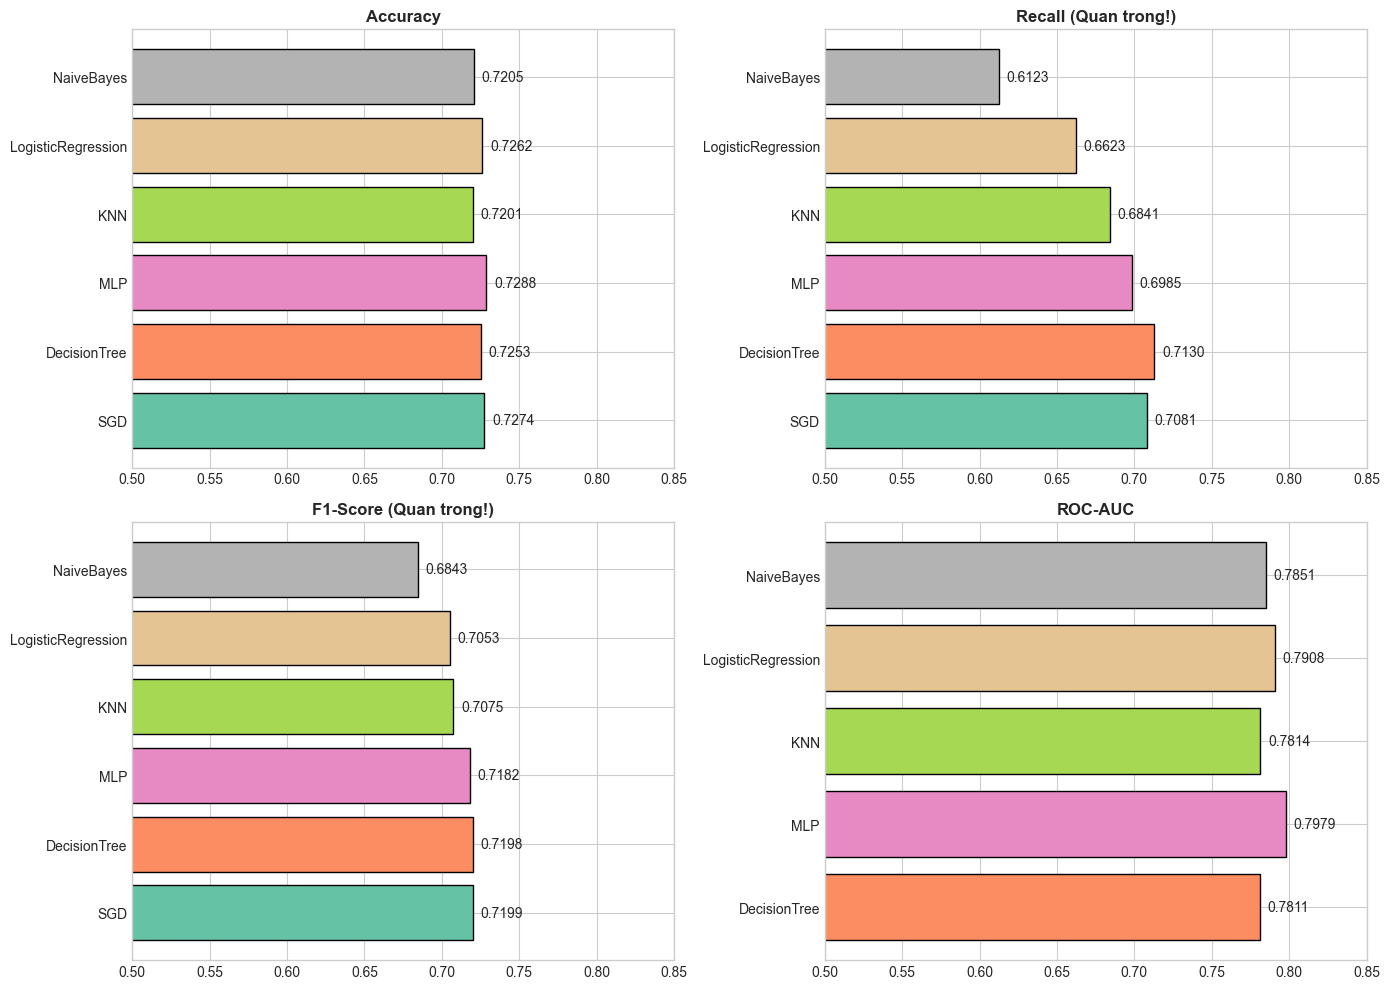

In [14]:
# Visualization so sanh
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['accuracy', 'recall', 'f1', 'roc_auc']
titles = ['Accuracy', 'Recall (Quan trong!)', 'F1-Score (Quan trong!)', 'ROC-AUC']
colors = plt.cm.Set2(np.linspace(0, 1, len(results_df)))

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i // 2, i % 2]
    values = results_df[metric].values
    models = results_df.index
    
    # Xu ly None values (voi SGD khong co ROC-AUC)
    valid_values = [v if v is not None else 0 for v in values]
    
    bars = ax.barh(models, valid_values, color=colors, edgecolor='black')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0.5, 0.85)
    
    # Them so lieu len bar
    for bar, val in zip(bars, values):
        if val is not None:
            ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
                    f'{val:.4f}', va='center', fontsize=10)
        else:
            ax.text(0.52, bar.get_y() + bar.get_height()/2, 
                    'N/A', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/single_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Luu Models va Ket qua

In [15]:
import os
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# Luu cac models
for model_name, model in trained_models.items():
    joblib.dump(model, f'models/single_{model_name.lower()}.pkl')
    print(f"Da luu: models/single_{model_name.lower()}.pkl")

# Luu best params
joblib.dump(best_params, 'models/best_params_single.pkl')
print("\nDa luu best_params_single.pkl")

# Luu ket qua
results_df.to_csv('outputs/single_models_results.csv')
print("Da luu outputs/single_models_results.csv")

Da luu: models/single_logisticregression.pkl
Da luu: models/single_knn.pkl
Da luu: models/single_naivebayes.pkl
Da luu: models/single_decisiontree.pkl
Da luu: models/single_mlp.pkl
Da luu: models/single_sgd.pkl

Da luu best_params_single.pkl
Da luu outputs/single_models_results.csv


## 7. Ket luan

**Cac Single Models da train:**
- Logistic Regression: Mo hinh tuyen tinh co ban
- KNN: Mo hinh dua tren khoang cach
- Naive Bayes: Mo hinh xac suat
- Decision Tree: Mo hinh cay quyet dinh don
- MLP Classifier: Mang no-ron don gian
- SGDClassifier: Linear SVM voi gradient descent (nhanh)

**Tiep theo:** Chuyen sang file 04 de train cac Ensemble Models (Random Forest, XGBoost, LightGBM, Bagging SVM, v.v.)